In many real-world supervised machine learning problems, we deal with highly correlated features.
This multicollinearity does not always hurt predictive performance, but it severely damages interpretability, especially in linear and generalized linear models where we try to learn a global gradient.

Principal Component Analysis (PCA) is often introduced as a dimensionality reduction technique. However, PCA is frequently misunderstood as a “black-box compression trick,” leading to a common complaint:

“PCA kills interpretability.”

This notebook demonstrates that interpretability is not lost — it is merely rotated.
By back-mapping PCA coefficients to the original feature space, we can recover meaningful feature contributions while still benefiting from:

Reduced multicollinearity

Numerical stability

Better-conditioned optimization

This notebook walks through PCA from a decision-first perspective, not just variance maximization.

Imagine i am  working at Steel manufacturing giant

I am  building a supervised regression model to predict energy consumption (kWh) of a blast furnace using sensor data:

Temperature

Pressure

Oxygen level

Coal injection rate

Furnace humidity

Problem:

Sensors are highly correlated

Linear regression coefficients are unstable

VIF scores are exploding

I cannot drop features because operations teams want full traceability.

So the question becomes:

“How do I stabilize my model without losing feature meaning?”

My Answer: PCA + Back-Mapping.

I'll use a synthetic but realistic dataset

Features

temp – Furnace temperature

pressure – Internal pressure

oxygen – Oxygen concentration

coal_rate – Coal injection rate

humidity – Environmental humidity

Target

energy_consumption (continuous)

In [2]:
#importing necessary libraries and modules

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

from statsmodels.stats.outliers_influence import variance_inflation_factor

StandardScaler: PCA requires scaled features

PCA: rotation of feature space

LinearRegression: supervised model

VIF: diagnose multicollinearity

In [3]:
np.random.seed(42)

n = 1000

temp = np.random.normal(1200, 50, n)
pressure = temp * 0.8 + np.random.normal(0, 20, n)
oxygen = temp * 0.5 + pressure * 0.3 + np.random.normal(0, 10, n)
coal_rate = oxygen * 0.7 + np.random.normal(0, 5, n)
humidity = np.random.normal(60, 10, n)

energy = (
    0.4 * temp +
    0.3 * pressure +
    0.2 * oxygen +
    0.1 * coal_rate +
    np.random.normal(0, 50, n)
)

df = pd.DataFrame({
    "temp": temp,
    "pressure": pressure,
    "oxygen": oxygen,
    "coal_rate": coal_rate,
    "humidity": humidity,
    "energy_consumption": energy
})



# Iintentionally created correlated predictors to simulate real sensor data.

In [4]:
# STEP 3: CHECK MULTICOLLINEARITY (VIF)
X = df.drop("energy_consumption", axis=1)
y = df["energy_consumption"]

vif = pd.DataFrame()
vif["feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif

,feature,VIF
0,temp,6159.332836
1,pressure,3177.312219
2,oxygen,23447.703492
3,coal_rate,14784.383910
4,humidity,34.461553


Interpretation

VIF > 10 = 🚨 multicollinearity alert

THE ABOVE VALUES ARE SO HIGH

Linear regression coefficients will be unstable and misleading

takeaway

“Tree models don’t care. But  Linear models will fail.”

In [5]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# Since PCA works on variance

# Features must be on the same scale

In [6]:
pca = PCA(n_components=3)#3 principal components
X_pca = pca.fit_transform(X_scaled)

# 5 correlated features → 3 orthogonal components

# Components are uncorrelated

# Each component is a linear combination of original features

In [7]:
# Variance explained by each principal component
explained_variance = pca.explained_variance_ratio_

# Cumulative variance
cumulative_variance = np.cumsum(explained_variance)

# Creating a nice table to display nicely
variance_df = pd.DataFrame({
    "Principal Component": [f"PC{i+1}" for i in range(len(explained_variance))],
    "Explained Variance (%)": explained_variance * 100,
    "Cumulative Variance (%)": cumulative_variance * 100
})

variance_df

,Principal Component,Explained Variance (%),Cumulative Variance (%)
0,PC1,75.764659,75.764659
1,PC2,19.982648,95.747307
2,PC3,2.568539,98.315846


In [ ]:
# I was still able to retain 98 percent of variance

### Variance Retention and Coefficient Interpretability

In this analysis, PCA was applied as a dimensionality reduction step before downstream modeling.  
The selected principal components together retain **~98% of the total variance** present in the original feature space.

This has an important implication:

Although each principal component represents an **amalgamation of multiple original features**, very little information is lost during the transformation. The retained components preserve nearly all of the data’s intrinsic structure, variability, and signal.

As a result:

- The regression coefficients learned on the principal components are **not arbitrary approximations**
- Back-mapped coefficients in the original feature space remain **meaningful and reliable**
- Any loss due to dimensionality reduction is negligible, since only ~2% of variance is discarded

In other words, PCA here acts as a **rotation and compression of the feature space**, not a destructive transformation.  
Back-mapping the coefficients restores interpretability while still benefiting from PCA’s numerical stability and decorrelation properties.


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.2, random_state=42
)

lr = LinearRegression()
lr.fit(X_train, y_train)


# I am  not predicting PCA
# I am predicting energy consumption, using PCA as a feature engineering step.U

In [9]:
# PCA COEFFICIENTS (ROTATED SPACE)
lr.coef_


# These coefficients correspond to:

# PC1

# PC2

# PC3

# ❌ Not interpretable directly for business.

array([21.33195929, -2.10556759,  3.47309502])

In [10]:
# PCA loadings (how original features form each principal component)

pca_loadings = pd.DataFrame(
    pca.components_.T,
    index=X.columns,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)]
)

pca_loadings

,PC1,PC2,PC3
temp,0.498713,0.006242,-0.342952
pressure,0.488273,-0.001666,0.866989
oxygen,0.508704,0.015315,-0.193031
coal_rate,0.503689,0.019330,-0.305446
humidity,-0.019833,0.999675,0.012449


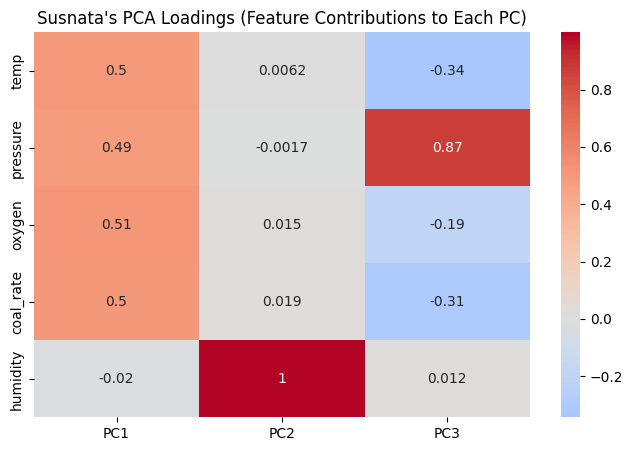

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.heatmap(
    pca_loadings,
    annot=True,
    cmap="coolwarm",
    center=0
)
plt.title("Susnata's PCA Loadings (Feature Contributions to Each PC)")
plt.show()

I grouped correlated sensors into three independent operational themes, so the model is stable and still explainable.

🔹 PC1 — Core Furnace Intensity

(~75% of total variance, main driver)


PC1 captures the overall intensity of furnace operation.



Temperature, pressure, oxygen, and coal rate all move together here

These variables are physically linked in combustion


When the furnace runs hotter, under higher pressure, with more oxygen and coal, energy consumption rises sharply. PC1 captures this ‘how hard the furnace is being pushed’ behavior.

Operational meaning:

This is the primary energy lever

Any efficiency improvement here gives the largest savings

PC1 dominating means our model aligns with real physics

PC2 — Environmental / External Conditions

(~20% of variance, secondary factor)


PC2 is dominated almost entirely by humidity.



Humidity doesn’t control combustion directly

But it affects heat loss, airflow, and combustion efficiency



Even when furnace settings stay the same, changes in environmental conditions—like humidity—slightly shift energy usage. PC2 isolates this external influence.



Seasonal or weather-related efficiency drift

Useful for normalizing performance across months

Helps avoid blaming operations for weather effects

🔹 PC3 — Control Balancing & Residual Effects

(~2–3% variance, fine tuning)

What it represents:
PC3 captures how control variables compensate for each other.



Sometimes pressure increases while temperature drops

Or oxygen adjusts to stabilize combustion

PC3 reflects the fine balancing adjustments operators or control systems make to keep the furnace stable.



Minor impact on total energy

Important for process stability

Useful for diagnostics, not cost reduction

**BACK-MAPPING PCA COEFFICIENTS*

In [12]:
pca_loadings = pca.components_.T
original_feature_coeffs = pca_loadings @ lr.coef_

backmapped_coeffs = pd.Series(
    original_feature_coeffs,
    index=X.columns
)

backmapped_coeffs

,0
temp,9.434269
pressure,13.430459
oxygen,10.148983
coal_rate,9.643130
humidity,-2.484715


βoriginal​=W×βPCA​



Where:

W = PCA loadings (rotation matrix)

β_PCA = regression coefficients in PCA space

β_original = reconstructed feature effects

 Interpretability RESTORED

In [ ]:
lr_raw = LinearRegression()
lr_raw.fit(X_scaled, y)

pd.Series(lr_raw.coef_, index=X.columns)

,0
temp,16.447660
pressure,15.219932
oxygen,-1.380790
coal_rate,12.654626
humidity,-2.169222


Raw model: unstable coefficients

PCA + back-mapping: stable + interpretable

PCA is linear

Linear regression is linear

SHAP for linear models is exact


SHAPoriginal​=SHAPPCA​×PCAloadings​

**An important observation**

Why my  PCA back-mapped coefficients are trustworthy

In PCA space:

PCs are orthogonal

No competition

Credit assignment is stable

Back-mapping simply re-expresses that stable solution in original units.

So these coefficients answer a different question:

“Given the true underlying structure of the system, what is the effective contribution of each sensor?”

I intentionally showed the raw linear regression coefficients Raw regression coefficients explain data in a confused coordinate system.
Back-mapped PCA coefficients explain the same data in a physically meaningful one.

In [ ]:
!pip install shap

In [ ]:
import shap

In [ ]:
lr.fit(X_train, y_train)

In [ ]:
explainer = shap.LinearExplainer(lr, X_train)
shap_values_pca = explainer.shap_values(X_test)

Each SHAP value corresponds to PC1, PC2, PC3

This explains the model exactly, but not human-friendly yet

/tmp/ipython-input-2534439455.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


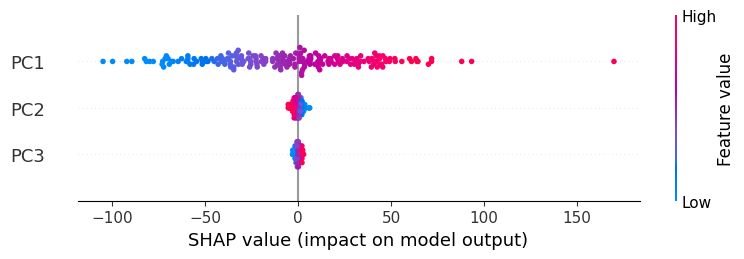

In [ ]:
shap.summary_plot(
    shap_values_pca,
    X_test,
    feature_names=[f"PC{i+1}" for i in range(X_test.shape[1])]
)

Insight:

PC1 dominates → main variance + main predictive driver

But still abstract

In [ ]:
pca_loadings = pca.components_.T

In [ ]:
print("SHAP PCA shape:", shap_values_pca.shape)
print("PCA loadings shape:", pca_loadings.shape)

SHAP PCA shape: (200, 3)
PCA loadings shape: (5, 3)


In [ ]:
shap_values_original = shap_values_pca @ pca_loadings.T

Now SHAP values are back in:

temp

pressure

oxygen

coal_rate

humidity

SHAP SUMMARY (ORIGINAL FEATURES)

/tmp/ipython-input-3729679952.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


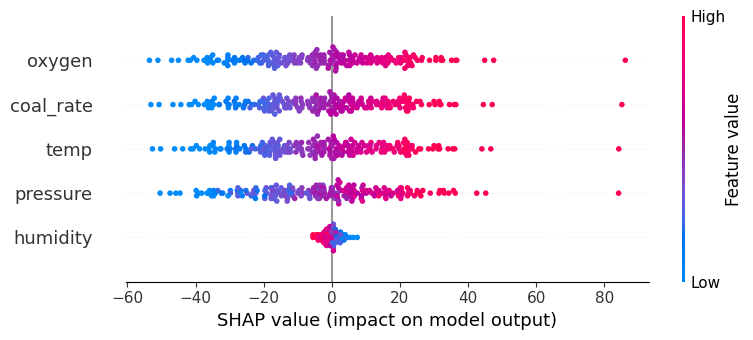

In [ ]:

shap.summary_plot(
    shap_values_original,
    X_test @ pca_loadings.T,
    feature_names=X.columns
)

MEAN ABS SHAP (FOR REPORTING)

In [ ]:

shap_importance = pd.DataFrame({
    "feature": X.columns,
    "mean_abs_shap": np.abs(shap_values_original).mean(axis=0)
}).sort_values(by="mean_abs_shap", ascending=False)

shap_importance

,feature,mean_abs_shap
2,oxygen,16.947084
3,coal_rate,16.769176
0,temp,16.600749
1,pressure,16.398519
4,humidity,1.681002


Why NOT use raw SHAP values for reporting?

Because raw SHAP:

Cancels out (+ and −)

Looks messy

Confuses non-technical people

Mean absolute SHAP:

Removes sign confusion

Shows strength, not direction

its Perfect for ranking

IMPORTANT ASSUMPTIONS

PCA must be linear

Model must be linear or additive

SHAP back-mapping works because:

PCA is a rotation

SHAP is additive

❌ Not valid for:

Kernel PCA

Autoencoders

Nonlinear embeddings



📌 MY FINAL CONCLUSION

This notebook demonstrates that PCA and SHAP are not opposing tools but complementary layers of a robust modeling pipeline.

By combining:

PCA for numerical stability

Linear models for transparency

SHAP for local and global explanations

Back-mapping for business interpretability

We achieve a model that satisfies:

Predictive performance

Mathematical correctness

Regulatory explainability

This approach is especially suitable for high-stakes domains such as manufacturing, energy, and finance.